# Code for Identifying and Evaluating the Best Feedback Vertex Set Subsets

Here we present our code to demonstrate how we ranked feedback vertex set (FVS) subsets to predict their ability to control the network. We present the code by finding and evaluating the 1-node subsets of the T-LGL network and use this to demonstrate how the graphs in the paper were generated.

In [1]:
import networkx as nx
from FVS_python import FVS as FVS
import pandas as pd
import itertools
import numpy as np
import scipy as sc
import numpy.linalg as la
import math
import scipy.stats as sp
import biolqm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Finding and ranking FVS subsets
This funciton takes as input a network in GraphML format and a FVS subset size (numNodes). By default, the three intersections from the paper are tested, but they can instead be modified to test any combination of the seven topological metrics. For different intersections, only the metric names `OutDegree`, `Distance`, `PRINCE`, `ModPRINCE`, `CheiRank`, `Cycles`, and `SCC` are recognized. The method returns the topolgocial values and intersection percentile cutoffs for the FVS subsets as two different Pandas DataFrames. 
<br><br>This code available to download and use at (insert Github when ready)

In [2]:
numNodes = 2
def findBestFVSSubsets(netName, numNodes, intersections = [['OutDegree','Distance','PRINCE','ModPRINCE','CheiRank','Cycles','SCC'],['PRINCE', 'ModPRINCE','CheiRank'],['ModPRINCE','CheiRank']]):
    net = nx.read_graphml(netName)
    revNet = nx.reverse(net)    
    metricDict = {0:'OutDegree', 1:'Distance', 2:'PRINCE', 3:'ModPRINCE', 4:'CheiRank', 5:'Cycles', 6:'SCC'}
    #functions
    def combos(nodes, num):
        combs = []
        combList = list(itertools.combinations(nodes, num))
        for comb in combList:
            combs.append(sorted(comb))
        return combs
    
    def averageValues(net, arr):
        nodes = list(net.nodes())
        combs = combos(nodes, numNodes)
        avgs = np.zeros(len(combs))
        combNames = []
        for i in range(len(combs)):
            comb = ''
            for j in range(len(combs[i])):
                comb += combs[i][j] + ', '
            combNames.append(comb[:-2])
            values = arr[i]
            j = 0
            while(j < len(values)):
                if(values[j] == -1):
                    values = np.delete(values,j)
                    j -= 1
                j += 1
            avgs[i] = np.sum(abs(values))/len(nodes)
        
        return pd.DataFrame({'Intervention':combNames,'Value':avgs})
    
    def distance(net, numPerts):
        nodes = list(net.nodes())
        combs = combos(nodes, numNodes)
        edges = list(net.edges(data = True))
        adj = np.asarray(nx.adjacency_matrix(net).todense()).astype(np.double)
        signedAdj = np.copy(adj)
        for edge in edges:
            source = edge[0]
            sink = edge[1]
            sign = edge[2]['data']
            if(sign == -1):
                signedAdj[nodes.index(source),nodes.index(sink)] = -1
        dist = np.zeros((len(combs),len(nodes)))
        for i in range(len(combs)):
            for j in range(len(nodes)):
                minDists = []
                for node in combs[i]:
                    try:
                        minDists.append(nx.shortest_path_length(net, node, nodes[j]))
                    except:
                        minDists.append(1E16)
                minDist = min(minDists)
                dist[i][j] = 1/(1+minDist)
        return averageValues(net, dist)
    
    def PRINCEPropagation(net, isModified):
        nodes = list(net.nodes())
        combs = combos(nodes, numNodes)
        edges = list(net.edges(data = True))
        adj = np.asarray(nx.adjacency_matrix(net).todense()).astype(np.double)
        signedAdj = np.copy(adj)
        for edge in edges:
            source = edge[0]
            sink = edge[1]
            sign = edge[2]['data']
            if(sign == -1):
                signedAdj[nodes.index(source),nodes.index(sink)] = -1
        inDegrees = np.zeros(len(nodes))
        outDegrees = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if(net.in_degree(nodes[i]) > 0):
                if(isModified):
                    inDegrees[i] = 1/net.in_degree(nodes[i])
                else:
                    inDegrees[i] = 1/(net.in_degree(nodes[i])**(1/2))
                    #inDegrees[i] = 1/(net.in_degree(nodes[i]))
            if(net.out_degree(nodes[i]) > 0):
                outDegrees[i] = 1/(net.out_degree(nodes[i])**(1/2))
        D1 = np.diag(outDegrees)
        D2 = np.diag(inDegrees)
        if(isModified):
            W = np.matmul(signedAdj, D2)
        else:
            W = np.matmul(D1,np.matmul(signedAdj,D2))
        a = 0.9
        numInputs = 2**(numNodes-1)
        i = 0
        j = 0
        negativeInputs = []
        while(i < numInputs):
            neg = combos(np.linspace(0,numNodes-1,numNodes), j)
            for n in neg:
                negativeInputs.append(n)
                i += 1
                if(i >= numInputs):
                    break  
            j += 1
        averages = np.zeros((len(combs),numInputs))
        for i in range(numInputs):
            Y = np.zeros((len(nodes),len(combs)))
            for c in combs:
                for node in c:
                    if(c.index(node) in negativeInputs[i]):
                        Y[nodes.index(node)][combs.index(c)] = -1
                    else:
                        Y[nodes.index(node)][combs.index(c)] = 1
            S = (1-a)*np.matmul(la.inv(np.identity(len(nodes))-a*W.transpose()),Y)
            combNames = []
            for j in range(len(combs)):
                comb = ''
                for k in range(len(combs[j])):
                    comb += combs[j][k] + ', '
                combNames.append(comb[:-2])
                for k in range(len(nodes)):
                    averages[j][i] += abs(S[k][j])/len(nodes)
        #maxOfAvgs = np.zeros((len(combs),1))
        maxOfAvgs = np.zeros(len(combs))
        for i in range(len(averages)):
            maxOfAvgs[i] = max(averages[i])
        return pd.DataFrame({'Intervention':combNames,'Value':maxOfAvgs})
    
    def pageRank(net):
        nodes = list(net.nodes())
        combs = combos(nodes, numNodes)
        combNames = []
        pR = nx.pagerank(net)
        result = np.zeros(len(combs))
        for i,comb in enumerate(combs):
            combName = ''
            notP = 1
            for c in comb:
                combName += c + ', '
                notP*=(1-pR[c])
            P = 1-notP
            result[i] = np.round(P, decimals = 3)
            combNames.append(combName[:-2])
        return pd.DataFrame({'Intervention':combNames,'Value':result})
    
    
    def nearestNeighbor(net):
        nodes = list(net.nodes())
        combs = combos(nodes, numNodes)
        outDegrees = []
        combNames = []
        for comb in combs:
            combName = ''
            outDegree = 0
            for c in comb:
                combName += c + ', '
                outDegree += net.out_degree(c)
            combNames.append(combName[:-2])
            outDegrees.append(outDegree)
        return pd.DataFrame({'Intervention':combNames,'Value':outDegrees})
    
    def findCycles():
        nodes  = df_cycles['node']
        cycleSize = df_cycles['cycles']
        combNames = []
        cycles = []
        for i in range(len(nodes)):
            combNames.append(nodes[i])
            cycles.append(cycleSize[i])
        return pd.DataFrame({'Intervention':combNames,'Value':cycles})
    
    def findSCC():
        nodes  = df_scc['node']
        sccSize = df_scc['scc']
        combNames = []
        scc = []
        for i in range(len(nodes)):
            combNames.append(nodes[i])
            scc.append(sccSize[i])
        return pd.DataFrame({'Intervention':combNames,'Value':scc})
    
    #Find FVS subsets and calculate FVS-specific metrics
    nodes_num=[]
    nodes_cycle=[]
    nodes_comb=[]
    nodes_combnum=[]
    nodes_scc=[]
    
    itrs=100
    print('Finding FVS Subsets')
    for i in range(itrs):
        #print(i,"%");
        G_FVS=FVS.FVS(net, randomseed = i)
        for n in range(numNodes,numNodes+1):
            addedCombs = []
            for comb in itertools.combinations(G_FVS,n):
                comb_ord=tuple(sorted(list(comb)))
                addedCombs.append(comb_ord)
                FVS2=[x for x in G_FVS if x not in comb_ord]
                H=net.copy()
                H.remove_nodes_from(FVS2)
                if(comb_ord not in nodes_comb):
                    nodes_comb.append(comb_ord)
                    nodes_num.append(1)
                    nodes_combnum.append(n)
                    cycles = nx.simple_cycles(H)
                    numPos = 0
                    for cycle in cycles:
                        negENum = 0
                        for j in range(len(cycle)):
                            if(H.get_edge_data(cycle[j],cycle[(j+1)%len(cycle)])['data'] == -1):
                                negENum += 1
                        if(negENum % 2 == 0):
                            numPos += 1
                    nodes_cycle.append(numPos)
                    nodes_scc.append(len(max(nx.strongly_connected_components(H), key=len)))
                else:
                    cycles = nx.simple_cycles(H)
                    numPos = 0
                    for cycle in cycles:
                        negENum = 0
                        for j in range(len(cycle)):
                            if(H.get_edge_data(cycle[j],cycle[(j+1)%len(cycle)])['data'] == -1):
                                negENum += 1
                        if(negENum % 2 == 0):
                            numPos += 1
                    index=nodes_comb.index(comb_ord)
                    nodes_cycle[index] = nodes_cycle[index] + numPos
                    nodes_num[index]=nodes_num[index]+1
                    nodes_scc[index]=nodes_scc[index]+len(max(nx.strongly_connected_components(H), key=len))
            for comb in itertools.combinations(net, n):
                comb_ord = tuple(sorted(list(comb)))
                if(comb_ord not in addedCombs):
                    if(comb_ord not in nodes_comb):
                        nodes_comb.append(comb_ord)
                        nodes_combnum.append(n)
                        nodes_cycle.append(0)
                        nodes_num.append(0)
                        nodes_scc.append(0)
    
    #print("100%")
    nodes_num=[x/itrs for x in nodes_num]
    nodes_cycle=[x/itrs for x in nodes_cycle]
    nodes_cycle2=[nodes_cycle[i]/nodes_num[i] if (nodes_num[i]!=0) else nodes_cycle[i] for i in range(len(nodes_cycle))]
    df_cycles=pd.DataFrame({"cycles": nodes_cycle2,"num": nodes_num,"combnum": nodes_combnum,"node":[", ".join(x) for x in nodes_comb]})
    df_cycles = df_cycles.sort_values(by = ['combnum','cycles','node'],ascending=False)
    
    nodes_scc=[x/itrs for x in nodes_scc]
    nodes_scc2=[nodes_scc[i]/nodes_num[i] if (nodes_num[i]!=0) else nodes_scc[i] for i in range(len(nodes_scc))]
    df_scc=pd.DataFrame({"scc": nodes_scc2, "num": nodes_num,"combnum": nodes_combnum,"node":[", ".join(x) for x in nodes_comb]})
    df_scc = df_scc.sort_values(by=['combnum','scc'],ascending=False)
    
    combs = list(df_cycles['node'])
    inFVS = list(df_cycles['num'])
    FVSsubsets = []
    FVScombos = []
    for i in range(len(combs)):
        if(inFVS[i] > 0):
            FVSsubsets.append(combs[i])
            FVScombos.append(combs[i].split(', '))
    print()
    print('Finding Topological Metric Values')
    #Create DataFrames for each Topological Metric
    metricValsDict = {}
    metricValsDict['OutDegree'] = nearestNeighbor(net)
    print('Out-Degree Done')
    metricValsDict['Distance'] = distance(net, False)
    print('Distance Done')
    metricValsDict['PRINCE'] = PRINCEPropagation(net, False)
    print('PRINCE Done')
    metricValsDict['ModPRINCE'] = PRINCEPropagation(net, True)
    print('Modified PRINCE Done')
    metricValsDict['CheiRank'] = pageRank(revNet)
    print('CheiRank Done')
    metricValsDict['Cycles'] = findCycles()
    print('Cycles Done')
    metricValsDict['SCC'] = findSCC()
    print('SCC Done')
    
    
    #Calculate Intersection Percentiles
    resultDict = {}
    topologyDict = {}
    FVSOnlyTopologyDict = {}
    
    for metricNum in range(7):
        df2 = metricValsDict[metricDict[metricNum]]
        perts2 = list(df2['Intervention'].values)
        topoVals = list(df2['Value'].values)
    
        for i in range(len(perts2)):
            if(perts2[i] in FVSsubsets):
                if(perts2[i] in FVSOnlyTopologyDict):
                    FVSOnlyTopologyDict[perts2[i]].append(topoVals[i])
                else:
                    FVSOnlyTopologyDict[perts2[i]] = [topoVals[i]]
                resultDict[perts2[i]] = []
            if(perts2[i] in  topologyDict):
                topologyDict[perts2[i]].append(topoVals[i])
            else:
                topologyDict[perts2[i]] = [topoVals[i]]
    
    for metrics in intersections:
        print()
        print('Calculating Percentile Cutoff values for Intersection '+str(intersections.index(metrics)+1))
        goodPerts = []
        for threshold in np.linspace(0.01,1,100):
            #print(str(int(100*(threshold-0.01)))+'%')
            goodPertsOld = goodPerts.copy()
            pertDict = {}
            pertDict2 = {}
            for metricNum in range(7):
                reverseTopologyDict = {}
                for k, v in FVSOnlyTopologyDict.items():
                    if(v[metricNum] in reverseTopologyDict):
                        reverseTopologyDict[v[metricNum]].append(k)
                    else:
                        reverseTopologyDict[v[metricNum]] = [k]
                A = []
                for k in FVSsubsets:
                    A.append(topologyDict[k][metricNum])
                topFVSPertsThresh = math.ceil(len(A)*threshold)
                
                topFVSPerts = []
                highestValsFVS = list(dict.fromkeys(sorted(A, reverse = True)[:topFVSPertsThresh]))
                for h in highestValsFVS:
                    for pert in reverseTopologyDict[h]:
                        topFVSPerts.append(pert)
                    if(len(topFVSPerts) >= topFVSPertsThresh):
                        break
                if(metricDict[metricNum] in metrics):
                    for t in topFVSPerts:
                        if(t in pertDict):
                            pertDict[t]+=1
                            pertDict2[t].append(metricDict[metricNum])
                        else:
                            pertDict[t]=1
                            pertDict2[t] = [metricDict[metricNum]]
            for k,v in pertDict.items():
                if(v == len(metrics)):
                    goodPerts.append(k)
            for i in range(len(goodPerts)):
                if(goodPerts[i] not in goodPertsOld):
                    resultDict[goodPerts[i]].append(np.round(1-threshold, decimals = 2))
        #print('100%')
    resultDict = {k:v for k,v in sorted(resultDict.items(), key = lambda item:item[1])}
    FVSsubsets = list(resultDict.keys())
    
    return pd.DataFrame(topologyDict, index = metricDict.values()).transpose(), pd.DataFrame(resultDict, index = [', '.join(intersection) for intersection in intersections]).transpose(), FVSsubsets
topoVals, interVals, subsets = findBestFVSSubsets('TLGL.graphml', numNodes)

Finding FVS Subsets

Finding Topological Metric Values
Out-Degree Done
Distance Done
PRINCE Done
Modified PRINCE Done
CheiRank Done
Cycles Done
SCC Done

Calculating Percentile Cutoff values for Intersection 1

Calculating Percentile Cutoff values for Intersection 2

Calculating Percentile Cutoff values for Intersection 3


In [3]:
topoVals

,OutDegree,Distance,PRINCE,ModPRINCE,CheiRank,Cycles,SCC
"A20, NFKB",12.0,0.286706,0.010724,0.020680,0.074,0.0,0.0
"A20, Apoptosis",1.0,0.195569,0.005625,0.004795,0.012,0.0,0.0
"A20, Caspase",3.0,0.205291,0.008037,0.006999,0.019,0.0,0.0
"A20, BID",4.0,0.208069,0.008384,0.007519,0.024,0.0,0.0
"A20, GZMB",4.0,0.210847,0.008539,0.006734,0.018,0.0,0.0
"A20, BclxL",2.0,0.201124,0.007570,0.005499,0.015,0.0,0.0
"A20, MCL1",2.0,0.202513,0.007520,0.005499,0.015,0.0,0.0
"A20, STAT3",9.0,0.275040,0.009471,0.011235,0.032,0.0,0.0
"A20, DISC",5.0,0.214458,0.008185,0.007259,0.020,0.0,0.0
"A20, CD45",3.0,0.234061,0.008056,0.006991,0.020,0.0,0.0


In [4]:
interVals

,"OutDegree, Distance, PRINCE, ModPRINCE, CheiRank, Cycles, SCC","PRINCE, ModPRINCE, CheiRank","ModPRINCE, CheiRank"
"CTLA4, IL2RA",0.00,0.00,0.00
"LCK, P2",0.00,0.00,0.00
"CTLA4, LCK",0.00,0.01,0.01
"IL2RA, TBET",0.00,0.22,0.37
"IL2RA, TCR",0.01,0.01,0.04
"LCK, TCR",0.01,0.05,0.05
"DISC, P2",0.02,0.02,0.02
"DISC, LCK",0.02,0.02,0.02
"CTLA4, P2",0.02,0.02,0.02
"IL2RA, LCK",0.02,0.02,0.03


## Evaluating the identified FVS subsets
After we predicted the ability for the FVS subsets to control the network, we evaluate our predictions using our devised *To Control* and *Away Control* metrics. This function utilizes the bioLQM package to simulate the dynamics of the network. It takes as input a Boolean network model in any of the import formats available in bioLQM and a list of subsets to be simulated. For multi-node subsets, they are added to the list as a comma  spearated list (e.g., the subset of NFKB and S1P would be in the list as the string`'NFKB, S1P'`). For each subset, every possibled intervention is simulated. To more parameters for this function are the number of simulations ran on the wild-type network (wtSims) and the number of simulations ran on each intervention (subsetSims). The function returns a Pandas DataFrame with the *To Control* and *Away Control* for each subset in the list of subsets.

In [5]:
def calculateToandAwayControl(netName, subsets, wtSims = 10, subsetSims = 10):
    
    def writePerturbation(subsets):
        perturbations = []
        for subset in subsets:
            nodes = [n.strip() for n in subset.split(',')]
            for i in range(2**len(nodes)):
                form = "{0:0"+str(len(nodes))+"b}"
                pertVals = list(form.format(i))
                perturbation = [nodes[j]+'%'+str(pertVals[j]) for j in range(len(nodes))]
                if(not (perturbation in perturbations) and len(perturbation) == len(nodes)):
                    perturbations.append(perturbation)
        return perturbations

    def willWrite(path):
        pd.set_option('display.max_colwidth', -1)
        ResultFile = open(path, "w")
        ResultFile.write(attDF.transpose().to_string())
        ResultFile.write("\n\n\n")
        ResultFile.write(resultHamming.transpose().to_string())
        ResultFile.close()
    
    lqm = biolqm.load(netName)
    nodes = [n.toString() for n in lqm.getComponents()]
    if(len(biolqm.fixpoints(lqm)) < len(biolqm.trapspaces(lqm))):
        trap = biolqm.trapspace(lqm)
        isComplex = True
    else:
        trap = biolqm.fixpoints(lqm)
        isComplex = False
    attDF = pd.DataFrame([s for s in trap])
    atts = attDF.values.astype(float)
    
    nodesResultOrder = list(attDF.columns)
    nonFixed = {i:[] for i in range(len(attDF))}
    
    if(isComplex):
        for i in range(len(atts)):
            for j in range(len(atts[i])):
                if(atts[i][j] > 1):
                    nonFixed[i].append(nodesResultOrder[j])
                    atts[i][j] = 0.5
    
    attTypes = {}
    
    attTypes['Type 0'] = [0]
    N = len(nodes)
    numAtts = len(atts)
    numTypes = 1
    for i in range(1,len(atts)):
        typeFound = False
        for j in range(numTypes):
            attType = 'Type ' + str(j)
            minDistance = 1
            for k in range(len(attTypes[attType])):
                aNum = attTypes[attType][k]
                distance = np.sum(abs(atts[aNum] - atts[i]))/len(nodes)
                if(distance < minDistance):
                    minDistance = distance
            if(minDistance <= 0.15 and not typeFound):
                attTypes[attType].append(i)
                typeFound = True
        if(not typeFound):
            attTypes['Type ' + str(numTypes)] = [i]
            numTypes += 1
    
    if(numTypes == 1):
        attTypes = {}
        for i in range(len(atts)):
            attTypes['Type ' + str(i)] = [i]
    
    combos = list(itertools.combinations(attTypes.keys(),2))
    diffs = np.zeros(len(combos))
    for i in range(len(combos)):
        type1 = combos[i][0]
        type2 = combos[i][1]
        att1 = atts[attTypes[type1][0]]
        att2 = atts[attTypes[type2][0]]
        diffs[i] = np.sum(abs(att1-att2))
    
    
    
    #Test Subsets
    pertNodes2 = [[]]
    pertNodes2.extend(writePerturbation(subsets))
    resultTableHamming = {}
    resultDict = {}
    
    np.random.seed(0)
    pertAttTargets = {}
    goodTo = {}
    goodAway = {}
    for subset in subsets:
        goodTo[subset] = False
        goodAway[subset] = False
    
    for perts in pertNodes2:
        if(perts == []):
            numSims = wtSims
        else:
            numSims = subsetSims
        result = np.zeros(numAtts)
        
        isBad = False
        perturbation = ""
        subset = ""
        for a in perts:
            node = a.split('%')[0]
            subset += node+', '
            perturbation += a
        subset = subset[:-2]
        pertAttTargets[perturbation] = []
        for i in range(numAtts):
            isTo = True
            for p in perts:
                node, val = p.split('%')
                val = int(val)
                if(attDF[node][i] != val):
                    isTo = False
            pertAttTargets[perturbation].append(isTo)
            
        if(sum(pertAttTargets[perturbation]) == numAtts):
            isBad = True
        if(sum(pertAttTargets[perturbation]) < numAtts):
            goodAway[subset] = True
            if(sum(pertAttTargets[perturbation]) > 0):
                goodTo[subset] = True
        if(len(perts) == 0):
            isBad = False
        
        if(isBad):
            print()
            print(perts,"Bad Intervention")
            resultTableHamming[perturbation] = []
            names = []
            for i in range(numAtts):
                resultTableHamming[perturbation].append(np.round(result[i], decimals = 3))
                if(i == numAtts):
                    names.append("    Middle")
                else:
                    names.append("    Attractor " + str(i))
            resultDict[perturbation] = [0,0]
            continue
        
        L = len(perts)
        pertNodeIndex = []
        print("\nPerturbing ", perts,"\n") 
        pert = lqm
        if(int(L)>=1):
            for n in perts:
                pert = biolqm.perturbation(pert, n)
                pertNode = n.split('%')[0]
                pertNodeIndex.append(nodesResultOrder.index(pertNode))
        pertFps = biolqm.fixpoints(pert)
        pertAtts2 = pd.DataFrame([s for s in pertFps])
        pertAtts = pertAtts2.values
        pertIsComplex = False
        
        if(len(biolqm.fixpoints(pert)) < len(biolqm.trapspaces(pert))):
            pertTrap = biolqm.trapspace(pert)
            pertIsComplex = True
        else:
            pertTrap = biolqm.fixpoints(pert)
            pertIsComplex = False
    
        pertAtts2 = pd.DataFrame([s for s in pertTrap])
        pertAtts = pertAtts2.values
        
        pertNonFixed = {i:[] for i in range(len(pertAtts))}
        if(pertIsComplex):
            for i in range(len(pertAtts)):
                for j in range(len(atts[0])):
                    if(pertAtts[i][j] > 1):
                        pertNonFixed[i].append(nodesResultOrder[j])
                        
        for i in range(numSims):
            if(numSims < 100):
                print("{0:2.0f}".format(i/numSims*100),"%")
            else:
                if(i%(numSims/100)==0):
                    print("{0:2.0f}".format(i/numSims*100),"%")
                    
            initial1 = np.random.randint(0,2**(N-10))
            initial2 = np.random.randint(0,2**10)
            form = "{0:0"+str(N-10)+"b}"
            initString1 = form.format(initial1)
            initString2 = "{0:010b}".format(initial2)
            initString = initString1+initString2
            
            isDone = False
            steps = 0
            while(not isDone and steps < 20):
                hamming = np.zeros(numAtts)
                hammingPerts = np.zeros(len(pertAtts))
                walk = biolqm.random(pert, "-i "+initString+" -m 50")
                Data = pd.DataFrame([s for s in walk])
                S = Data.values[-1]
                steps += 1
                for j in range(len(hamming)):
                    for k in range(len(S)):
                        if(k not in pertNodeIndex and nodesResultOrder[k] not in nonFixed[j]):
                            hamming[j] += abs(atts[j][k]-S[k])
                if(pertIsComplex):
                    for j in range(len(hammingPerts)):
                        for k in range(len(S)):
                            if(nodesResultOrder[k] not in pertNonFixed[j]):
                                hammingPerts[j] += abs(pertAtts[j][k]-S[k])
                else:
                    for j in range(len(hammingPerts)):
                        hammingPerts[j] = np.sum(abs(pertAtts[j]-S))
                
                initString = ""
                for node in nodes:
                    initString += str(Data[node].values[-1])
    
                if(min(hammingPerts) == 0.0):
                    isDone = True  
    
            hamming = hamming/(len(nodes)-(len(pertNodeIndex)))
            minValue = min(hamming)
            
            bestAtt = np.where(hamming == minValue)[0][0]
            
            closeThreshold = min(diffs)/len(nodes)/2
            
            if(minValue <= closeThreshold):
                result[bestAtt] += 1-minValue/closeThreshold
    
        print ("100%")
        resultTableHamming[perturbation] = []
        names = []
        for i in range(len(hamming)):
            resultTableHamming[perturbation].append(np.round(result[i]/numSims, decimals = 3))
            names.append("    Attractor " + str(i))
            
        WTTB, WTNTB, TB, NTB = 0,0,0,0
        for i in range(numAtts):
            if(pertAttTargets[perturbation][i]):
                WTTB += resultTableHamming[''][i]
                TB += resultTableHamming[perturbation][i]
            else:
                WTNTB += resultTableHamming[''][i]
                NTB += resultTableHamming[perturbation][i]
                
        toControl, awayControl = 0,0
        if(sum(pertAttTargets[perturbation]) < numAtts and sum(pertAttTargets[perturbation]) > 0):
            if(TB >= WTTB):
                toControl = (TB-WTTB)/(1-WTTB)
            else:
                toControl = (TB-WTTB)/WTTB
            if(NTB >= WTNTB):
                awayControl = (WTNTB-NTB)/(1-WTNTB)
            else:
                awayControl = (WTNTB-NTB)/WTNTB
        
        elif(sum(pertAttTargets[perturbation]) < numAtts):
            awayControl = WTNTB - NTB
        
        resultDict[perturbation] = [np.round(toControl, decimals = 2), np.round(awayControl, decimals = 2)]
    
    resultHamming = pd.DataFrame(resultTableHamming, index = names).transpose()
    #pertResults = pd.DataFrame(resultDict, index = ['To Control','Away Control']).transpose()
    
    combResultDict = {}
    for perts in pertNodes2:
        perturbation = ''
        subset = ''
        for a in perts:
            node = a.split('%')[0]
            perturbation += a
            subset += node+', '
        subset = subset[:-2]
        if(subset in combResultDict):
            if(resultDict[perturbation][0] > combResultDict[subset][0]):
                combResultDict[subset][0] = resultDict[perturbation][0]
            if(resultDict[perturbation][1] > combResultDict[subset][1]):
                combResultDict[subset][1] = resultDict[perturbation][1]
        else:
            combResultDict[subset] = resultDict[perturbation]
            
    results = pd.DataFrame(combResultDict, index = ['To Control','Away Control']).transpose().drop('')
    return results, goodTo, goodAway

controlVals, goodTo, goodAway = calculateToandAwayControl('TLGL.booleannet', subsets)


Perturbing  [] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'IL2RA%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'IL2RA%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%1', 'IL2RA%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%1', 'IL2RA%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['LCK%0', 'P2%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['LCK%0', 'P2%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['LCK%1', 'P2%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['LCK%1', 'P2%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'LCK%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'LCK%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%1', 'GAP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'IL2RA%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'IL2RA%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'IL2RA%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'IL2RA%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'FLIP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%0', 'FLIP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%1', 'FLIP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['CTLA4%1', 'FLIP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'LCK%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'LCK%1']

20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'GAP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'GAP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'GAP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'GAP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'ZAP70%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'ZAP70%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%1', 'ZAP70%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%1', 'ZAP70%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GRB2%0', 'TCR%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GRB2%0', 'TCR%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GRB2%1', 'TCR%0'] 

 0 %
10 %
20 %
3

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'GRB2%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'FLIP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%0', 'FLIP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'FLIP%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['BID%1', 'FLIP%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['RAS%0', 'ZAP70%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['RAS%0', 'ZAP70%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

['RAS%1', 'ZAP70%0'] Bad Intervention

Perturbing  ['RAS%1', 'ZAP70%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%0', 'S1P%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%0', 'S1P%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Pert

60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%0', 'IL2RB%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

['GAP%0', 'IL2RB%1'] Bad Intervention

Perturbing  ['GAP%1', 'IL2RB%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%1', 'IL2RB%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'RAS%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%0', 'RAS%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%1', 'RAS%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['FLIP%1', 'RAS%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%0', 'JAK%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

['GAP%0', 'JAK%1'] Bad Intervention

Perturbing  ['GAP%1', 'JAK%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%1', 'JAK%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

90 %
100%

Perturbing  ['RAS%1', 'S1P%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['RAS%1', 'S1P%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['JAK%0', 'S1P%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['JAK%0', 'S1P%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['JAK%1', 'S1P%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['JAK%1', 'S1P%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%0', 'NFKB%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

['GAP%0', 'NFKB%1'] Bad Intervention

Perturbing  ['GAP%1', 'NFKB%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['GAP%1', 'NFKB%1'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['DISC%0', 'NFKB%0'] 

 0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100%

Perturbing  ['DISC%0', 'NFKB%1'] 

 0 %
10 %
20 %
30 %
4

In [6]:
controlVals

,To Control,Away Control
"CTLA4, IL2RA",0.00,0.50
"LCK, P2",0.50,0.63
"CTLA4, LCK",0.00,0.30
"IL2RA, TBET",0.00,1.00
"IL2RA, TCR",0.00,0.50
"LCK, TCR",0.00,0.50
"DISC, P2",0.60,1.00
"DISC, LCK",0.29,0.84
"CTLA4, P2",0.00,0.50
"IL2RA, LCK",0.00,0.60


### Construction of Figure 4
After calculating the topological metric values and control values, we plot them against each other to generate a scatter plot. A logistic regression is applied to this scatter plot and used to generate a Precision-Recall Curve and AUPRC value.

              precision    recall  f1-score   support

       False       0.70      0.65      0.67        46
        True       0.82      0.85      0.83        84

    accuracy                           0.78       130
   macro avg       0.76      0.75      0.75       130
weighted avg       0.77      0.78      0.78       130

Random Threshold: 0.65 
Success Threshold: 0.82 
AUPRC: 0.9


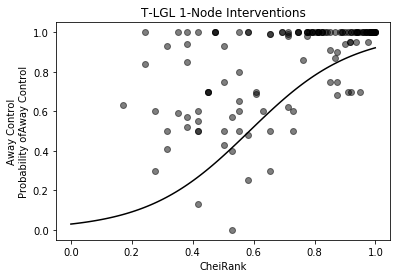

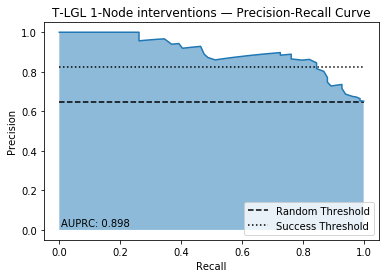

In [7]:
topoMetric = 'CheiRank'
controlMetric = 'Away Control'
topoDF = topoVals[topoMetric].rank()/len(topoVals)
tV = topoDF.to_dict()
cV = controlVals[controlMetric].to_dict()
x = []
y = []
for k in tV.keys():
    if k in subsets:
        x.append(tV[k])
        y.append(cV[k])

x = np.array(x).reshape(-1,1)
y = np.array(y)
yTrue = y >= 0.9
plt.figure(0)
plt.plot(x, y, 'ko', alpha = 0.5)
logReg = LogisticRegression(random_state = 0, C = 1000000000.0, solver = 'liblinear').fit(x,yTrue)
xFit = np.linspace([0],max(x),100)
yFit = logReg.predict_proba(xFit)[:,1]
plt.xlabel(topoMetric)
plt.ylabel(controlMetric+'\nProbability of'+controlMetric)
plt.title('T-LGL 1-Node Interventions')
plt.plot(xFit, yFit, 'k')
yPred = logReg.predict(x)
yScore = logReg.predict_proba(x)[:,1]
posFraction = sum(yTrue)/len(yTrue)
AUPRCThresh = 1-(1-posFraction)/2
plt.figure(1)
AUPRC = metrics.average_precision_score(yTrue, yScore)
A,B,C = metrics.precision_recall_curve(yTrue, yScore)
plt.plot(B, A)
plt.fill_between(B, A, alpha = 0.5)
plt.hlines(posFraction, 0,1,linestyles = '--', label = 'Random Threshold')
plt.hlines(AUPRCThresh, 0,1, linestyles = ':', label = 'Success Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('T-LGL 1-Node interventions — Precision-Recall Curve')
plt.legend(loc = 4)
plt.annotate('AUPRC: '+str(np.round(AUPRC,3)), (17,14), xycoords = 'axes points')
print(metrics.classification_report(yTrue, yPred))
print('Random Threshold:',np.round(posFraction, decimals = 2),\
      '\nSuccess Threshold:',np.round(AUPRCThresh, decimals = 2),\
      '\nAUPRC:',np.round(metrics.average_precision_score(yTrue, yScore), decimals = 2))

### Construction of Figures 6 and 7
The intersection percentile cutoff values are also compared to the control values to create figure 6. The precision and number of identified subsets at each percentile cutoff value are also plotted against each other to construct figure 7. The crossing points of the graphs represented by figure 7 are used to find generalizable percentile cutoff values.

0.95 Precsion Crossing Point: 0.42


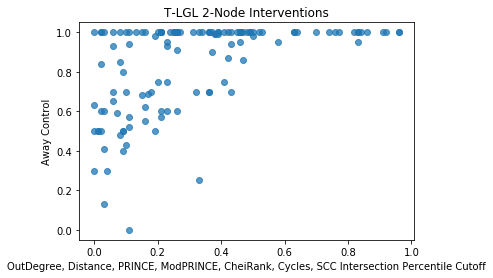

<Figure size 432x288 with 0 Axes>

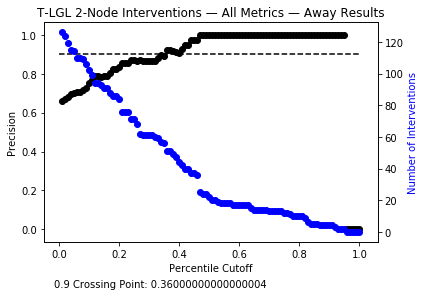

In [8]:
intersection = 'OutDegree, Distance, PRINCE, ModPRINCE, CheiRank, Cycles, SCC'
controlMetric = 'Away Control'
tV = interVals[intersection].to_dict()
cV = controlVals[controlMetric].to_dict()
x = []
y = []
for k in tV.keys():
    x.append(tV[k])
    y.append(cV[k])

x = np.array(x).reshape(-1,1)
y = np.array(y)
yTrue = y >= 0.9
plt.figure(0)
plt.plot(x, y, 'o', alpha = 0.75)
plt.xlabel(intersection+' Intersection Percentile Cutoff')
plt.ylabel(controlMetric)
plt.title('T-LGL '+str(numNodes)+'-Node Interventions')

thresholdTests = np.linspace(0.01, 1, 100)
precisionPoint = 1
precisionPoints = []
for t in thresholdTests:
    tp, fp = 0,0
    for i in range(len(x)):
        if(x[i] >= t and y[i] >= 0.9):
            tp += 1
        elif(x[i] >= t):
            fp += 1
    if(tp+fp > 0):
        precision = tp/(tp+fp)
    else:
        precision = 0
    precisionPoints.append(precision)
    if(precision >= 0.95):
        precisionPoint = min(t, precisionPoint)
    

plt.figure(1)
thresholds = np.linspace(0.01,1,100)
precisions = []
numSubsets = []
for t in thresholds:
    num = 0
    tp, fp = 0,0
    for subset in list(interVals.index):
        if(interVals[intersection][subset] >= t):
            num += 1
            if(controlVals[controlMetric][subset] >= 0.9):
                tp += 1
            else:
                fp += 1
    precision = 0
    if(tp + fp > 0):
        precision = tp/(tp+fp)
    numSubsets.append(num)
    precisions.append(precision)

fig, ax1 = plt.subplots()
ax1.scatter(thresholds, precisions, color = 'k')
ax2 = ax1.twinx()
ax2.scatter(thresholds, numSubsets, color = 'b')
ax1.hlines(0.9, 0, 1, linestyles = 'dashed')
ax1.set_xlabel('Percentile Cutoff')
ax1.set_ylabel('Precision')
ax2.set_ylabel('Number of Interventions', color = 'b')
cross = 1
for i in range(len(thresholds)-1):
    if(precisions[i] < 0.9 and precisions[i+1] >= 0.9):
        cross = min(cross, thresholds[i+1])
        
plt.title('T-LGL '+str(numNodes)+'-Node Interventions — All Metrics — Away Results')
fig.tight_layout()
s = '0.9 Crossing Point: '+str(cross)
plt.annotate(s, (10,-45), xycoords = 'axes points')

print('0.95 Precsion Crossing Point:',np.round(precisionPoint, decimals = 2))

Bootstrap/Random

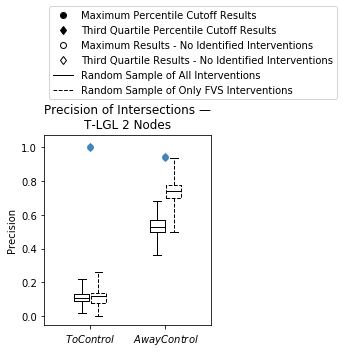

In [9]:
#intersection = 'OutDegree, Distance, PRINCE, ModPRINCE, CheiRank, Cycles, SCC'
intersection = 'PRINCE, ModPRINCE, CheiRank'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

def bootstrap(data, numBootstrap):
    bootMeans = []
    np.random.seed(0)
    for _ in range(numBootstrap):
        bootData = np.random.choice(data, size = len(data), replace = True)
        bootMeans.append(bootData.mean())
    return bootMeans

randomSample = pd.read_excel('TLGLRandomResults.xlsx', index_col = 0)
randomFVSSample = pd.read_excel('TLGLRandomFVSResults.xlsx', index_col = 0)
randomControlDict = {}
randomFVSControlDict = {}

for i in range(len(randomSample)):
    pert = randomSample.index[i]
    vals = randomSample.values[i]
    num = len(pert.split(','))
    if(num == numNodes):
        randomControlDict[pert] = list(vals)
for i in range(len(randomFVSSample)):
    pert = randomFVSSample.index[i]
    vals = randomFVSSample.values[i]
    num = len(pert.split(','))
    if(num == numNodes):
        randomFVSControlDict[pert] = list(vals)

randomTos = (np.array(list(randomControlDict.values()))>=0.9)[:,0]
randomAways = (np.array(list(randomControlDict.values()))>=0.9)[:,1]
randomFVSTos = (np.array(list(randomFVSControlDict.values()))>=0.9)[:,0]
randomFVSAways =  (np.array(list(randomFVSControlDict.values()))>=0.9)[:,1]


randomBoot = np.array([bootstrap(randomTos, 1000), bootstrap(randomAways, 1000)]).transpose()
randomFVSBoot = np.array([bootstrap(randomFVSTos, 1000), bootstrap(randomFVSAways, 1000)]).transpose()

fig, ax = plt.subplots(figsize = (3,3.5))
bp1 = ax.boxplot(randomBoot, whis = [0,100], widths = 0.2, medianprops = dict(color = 'k'), positions = 0.89+np.arange(2))
bp2 = ax.boxplot(randomFVSBoot,whis = [0,100], widths = 0.2, boxprops = dict(linestyle = '--'), whiskerprops = dict(linestyle = '--'), medianprops = dict(color = 'k'), positions = 1.11+np.arange(2))
ax.set_xticks(1+np.arange(2))
ax.set_xticklabels(["$\it{To Control}$","$\it{Away Control}$"])

toGoodMax, toNumMax, toGoodQ3, toNumQ3, awayGoodMax, awayNumMax, awayGoodQ3, awayNumQ3 = 0, 0, 0, 0, 0, 0, 0, 0

for subset in subsets:
    if(goodTo[subset]):
        if(interVals[intersection][subset] >= 0.91):
            toNumMax += 1
            if(controlVals['To Control'][subset] >= 0.9):
                toGoodMax += 1
        if(interVals[intersection][subset] >= 0.87):
            toNumQ3 += 1
            if(controlVals['To Control'][subset] >= 0.9):
                toGoodQ3 += 1
    if(goodAway[subset]):
        if(interVals[intersection][subset] >= 0.80):
            awayNumMax += 1
            if(controlVals['Away Control'][subset] >= 0.9):
                awayGoodMax += 1
        if(interVals[intersection][subset] >= 0.61):
            awayNumQ3 += 1
            if(controlVals['Away Control'][subset] >= 0.9):
                awayGoodQ3 += 1


if(toNumMax > 0):
    ax.scatter(1, toGoodMax/toNumMax, c= CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(1, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')
if(toNumQ3 > 0):
    ax.scatter(1, toGoodQ3/toNumQ3, c= CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(1, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')

if(awayNumMax > 0):
    ax.scatter(2, awayGoodMax/awayNumMax, c= CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(2, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'o', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')
if(awayNumQ3 > 0):
    ax.scatter(2, awayGoodQ3/awayNumQ3, c= CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics')
else:
    ax.scatter(2, 0, c = 'none', edgecolor = CB_color_cycle[0], marker = 'd', alpha = 0.75, label = 'Intersection of All Metrics - No Identified Interventions')

ax.set_ylabel('Precision')
ax.set_title('Precision of Intersections —\nT-LGL '+str(numNodes)+' Nodes')

circle_patch = mlines.Line2D([],[],linestyle='None', marker = 'o', color = 'k', label = 'Circle')
diamond_patch = mlines.Line2D([],[],linestyle='None', marker = 'd', color = 'k', label = 'Diamond')
empty_circle_patch = mlines.Line2D([],[],linestyle='None', marker = 'o', color = 'k', label = 'Circle', fillstyle='none')
empty_diamond_patch = mlines.Line2D([],[],linestyle='None', marker = 'd', color = 'k', label = 'Diamond', fillstyle='none')

plt.legend([circle_patch, diamond_patch, empty_circle_patch, empty_diamond_patch, bp1['boxes'][0], bp2['boxes'][0]],\
           ['Maximum Percentile Cutoff Results','Third Quartile Percentile Cutoff Results','Maximum Results - No Identified Interventions','Third Quartile Results - No Identified Interventions','Random Sample of All Interventions','Random Sample of Only FVS Interventions'],\
           loc = 'upper left', bbox_to_anchor = (0,1.7))
